In [1]:
import pyads
from ctypes import sizeof
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import EarthLocation, Longitude, SkyCoord, get_sun, AltAz
from astropy import units as u
import datetime
from time import sleep
import matplotlib.pyplot as plt
import numpy as np

In [2]:
'''
ADSSTATES:
{
    Invalid = 0,
    Idle = 1,
    Reset = 2,
    Init = 3,
    Start = 4,
    Run = 5,
    Stop = 6,
    SaveConfig = 7,
    LoadConfig = 8,
    PowerFailure = 9,
    PowerGood = 10,
    Error = 11,
    Shutdown = 12,
    Suspend = 13,
    Resume = 14,
    Config = 15,
    Reconfig = 16,
    Maxstates = 17,
}
'''

'\nADSSTATES:\n{\n    Invalid = 0,\n    Idle = 1,\n    Reset = 2,\n    Init = 3,\n    Start = 4,\n    Run = 5,\n    Stop = 6,\n    SaveConfig = 7,\n    LoadConfig = 8,\n    PowerFailure = 9,\n    PowerGood = 10,\n    Error = 11,\n    Shutdown = 12,\n    Suspend = 13,\n    Resume = 14,\n    Config = 15,\n    Reconfig = 16,\n    Maxstates = 17,\n}\n'

In [3]:
# for simple connection follow instructions of:
# http://soup01.com/en/2022/06/02/beckhoffusing-python-to-communicate-with-twincat-by-ads/

ads_net_id = '134.76.204.249.1.1' # net_id of PLC -> look at SYSTEM/Tasks/Routes
plc = pyads.Connection(ads_net_id, pyads.PORT_TC3PLC1) # create plc object with net_id and port 851
'''
print("Connecting to TwinCAT PLC..")
plc.open() # open plc connection
print("Current connection status:",plc.is_open)
print("Current Status:",plc.read_state())

print("Closing the Connections..")
plc.close()
print("Current Status:",plc.is_open)
'''
def test_JD2LST(time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m).geodetic
    #LST time
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')


    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    lat_b = plc.get_symbol('MAIN.lat')
    lon_b = plc.get_symbol('MAIN.lon')
    height_b = plc.get_symbol('MAIN.height')
    jd1_b = plc.get_symbol('MAIN.jd1')
    lst1_b = plc.get_symbol('MAIN.lst1')

    # write values to symbols
    lat_b.write(loc[0])
    lon_b.write(loc[1])
    height_b.write(loc[2])
    jd1_b.write(timeJD_astro)
    # change estate to execute test -> 5 == test_state.JD2LST
    plc.write_by_name(data_name='MAIN.estate', value=5,plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.05) # new cyle of twincat
    # get LST value
    LST_beck =  lst1_b.read()
    plc.close()
    #------------------------------------------------------------------------------------------
    return np.array([LST_astro.degree, LST_beck, LST_astro.degree-LST_beck])

def test_EQ2HOR(coord_eq, time = datetime.datetime.now(), loc = [51.55931126132681, 9.945392608768366, 200]) -> np.array([]):
    # all values with _astro are computed using astropy
    # _beck are values from beckhoff
    # loc [lat deg,lon deg, height m], standart is IAG telescope
    
    # JD time
    timeJD_astro = Time(time).jd
    
    # obs location
    loc_astro = EarthLocation(lat=loc[0]*u.deg, lon=loc[1]*u.deg, height=loc[2]*u.m)
    LST_astro =  Time(timeJD_astro, format='jd', location=loc_astro).sidereal_time('apparent')
    # Astropy coord-trafo
    coord_eq_astro = SkyCoord(ra=coord_eq[0]*u.degree, dec=coord_eq[1]*u.degree)
    
    altaz_frame = AltAz(location=loc_astro, obstime=Time(time))
    coord_hor_astro = coord_eq_astro.transform_to(altaz_frame)
    #coord_hor_trafo = radec2altaz(coord_eq[0],coord_eq[1],loc[0],loc[1],LST_astro.degree)
    #------------------------------------------------------------------------------------------
    plc.open() # open plc connection

    # get relevant symbols _b for beckhoff
    lat_b = plc.get_symbol('MAIN.lat')
    lon_b = plc.get_symbol('MAIN.lon')
    height_b = plc.get_symbol('MAIN.height')
    jd1_b = plc.get_symbol('MAIN.jd1')
    ra_b = plc.get_symbol('MAIN.ra')
    dec_b = plc.get_symbol('MAIN.dec')
    alt_b = plc.get_symbol('MAIN.alt')
    az_b = plc.get_symbol('MAIN.az')
    lst1_b = plc.get_symbol('MAIN.lst1')
    # write values to symbols
    lst1_b.write(LST_astro.degree)
    lat_b.write(loc[0])
    lon_b.write(loc[1])
    height_b.write(loc[2])
    jd1_b.write(timeJD_astro)
    ra_b.write(coord_eq[0])
    dec_b.write(coord_eq[1])
    # change estate to execute test -> 2 == test_state.EQ2HOR
    plc.write_by_name(data_name='MAIN.estate', value=2, plc_datatype=pyads.PLCTYPE_INT)
    sleep(0.05) # new cyle of twincat
    # get LST value
    alt_beck =  alt_b.read()
    az_beck = az_b.read()
    plc.close()
    #------------------------------------------------------------------------------------------
    
    return np.array([[alt_beck, az_beck],[coord_hor_astro.alt.degree, coord_hor_astro.az.degree]])
    



Starting test!
Testing...
Finished!


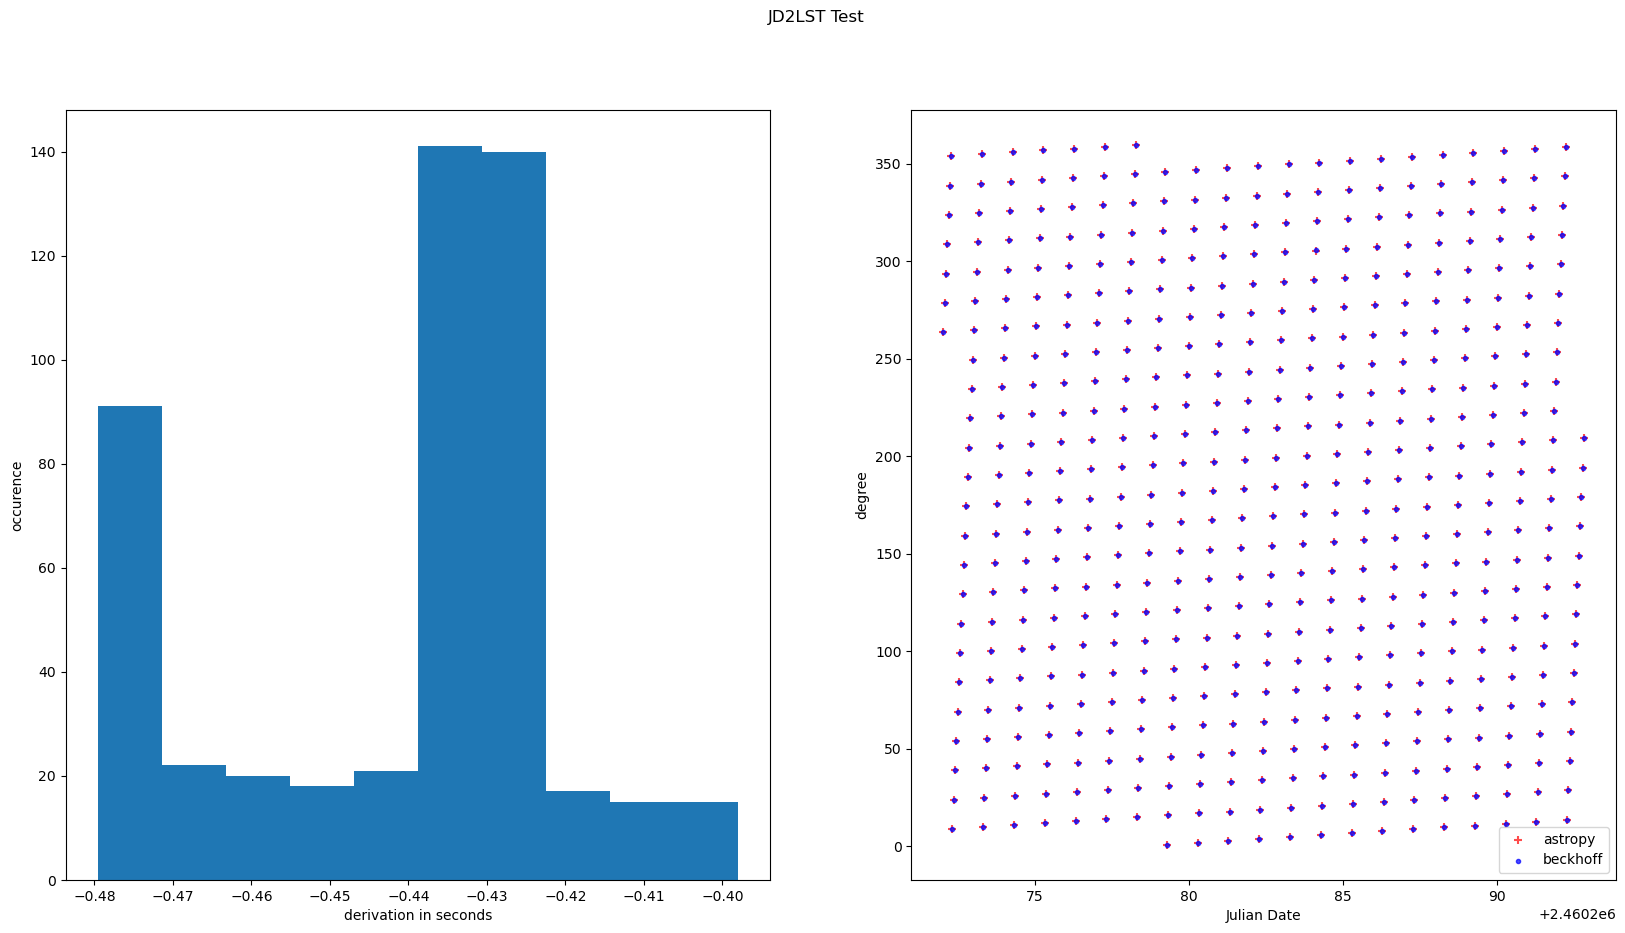

In [62]:
# test JD2LST
print('Starting test!')
now =  datetime.datetime.now()
# make time series
ts = TimeSeries(time_start=now,
                 time_delta=60 * u.min,
                 n_samples=500)
print('Testing...')
results = np.array([test_JD2LST(time) for time in ts.time])
print('Finished!')


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('JD2LST Test')
axs[0].hist(results[:,2]*3600/15)
axs[0].set_xlabel('derivation in seconds')
axs[0].set_ylabel('occurence')

axs[1].scatter(ts.time.jd, results[:,0], marker='+', alpha=0.7, c='red', label='astropy')
axs[1].scatter(ts.time.jd, results[:,1], marker='.', alpha=0.7, c= 'blue', label='beckhoff')
axs[1].set_xlabel('Julian Date')
axs[1].set_ylabel('degree')
axs[1].legend()
plt.show()

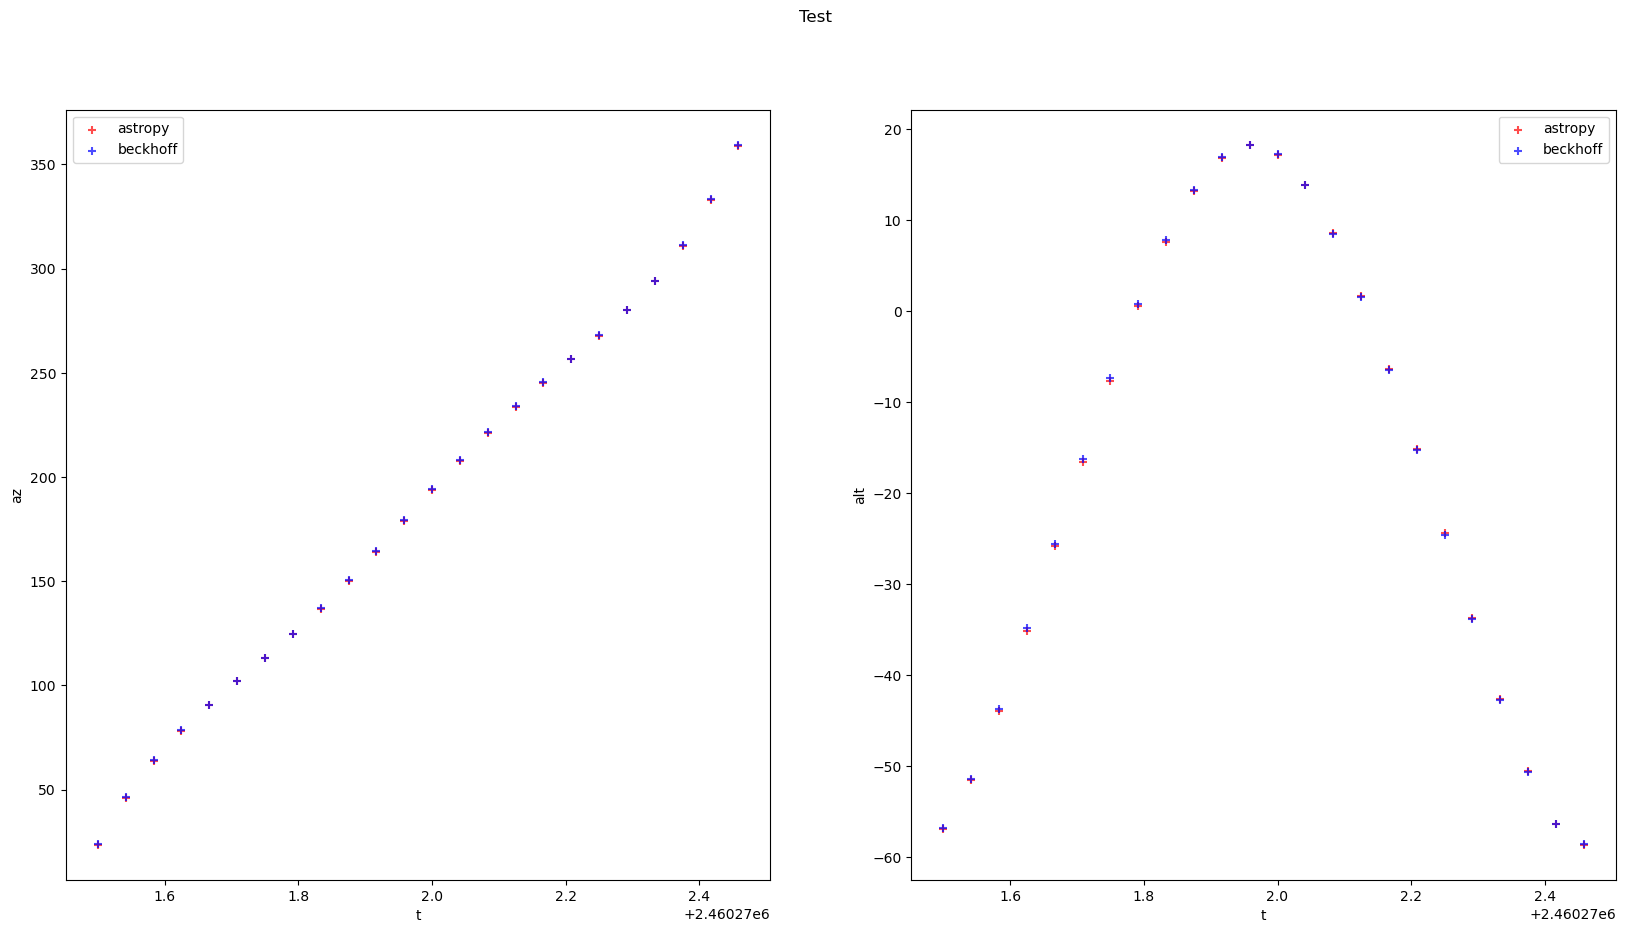

In [46]:
#Horizons sun position
time = datetime.datetime(2023, 11, 23, 0, 0, 0)
coord_sun = np.array([237.91670, -20.16854])
ts = TimeSeries(time_start=time,
                 time_delta=60 * u.min,
                 n_samples=24)
# Hoizons Alt Az for the following location: Alt:-56.970989, Az:23.511494
results=np.array([test_EQ2HOR(coord_sun, t,[51.55931126132681, 9.945392608768366, 200]) for t in ts.time ])
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Test')
axs[0].scatter(ts.time.jd, results[:,1,1], marker='+', alpha=0.7, c='red', label='astropy')
axs[0].scatter(ts.time.jd, results[:,0,1], marker='+', alpha=0.7, c='blue', label='beckhoff_simple')
axs[0].set_xlabel('t')
axs[0].set_ylabel('az')
axs[0].legend()

axs[1].scatter(ts.time.jd, results[:,1,0], marker='+', alpha=0.7, c='red', label='astropy')
axs[1].scatter(ts.time.jd, results[:,0,0], marker='+', alpha=0.7, c='blue', label='beckhoff_simple')
axs[1].set_xlabel('t')
axs[1].set_ylabel('alt')
axs[1].legend()
plt.show()

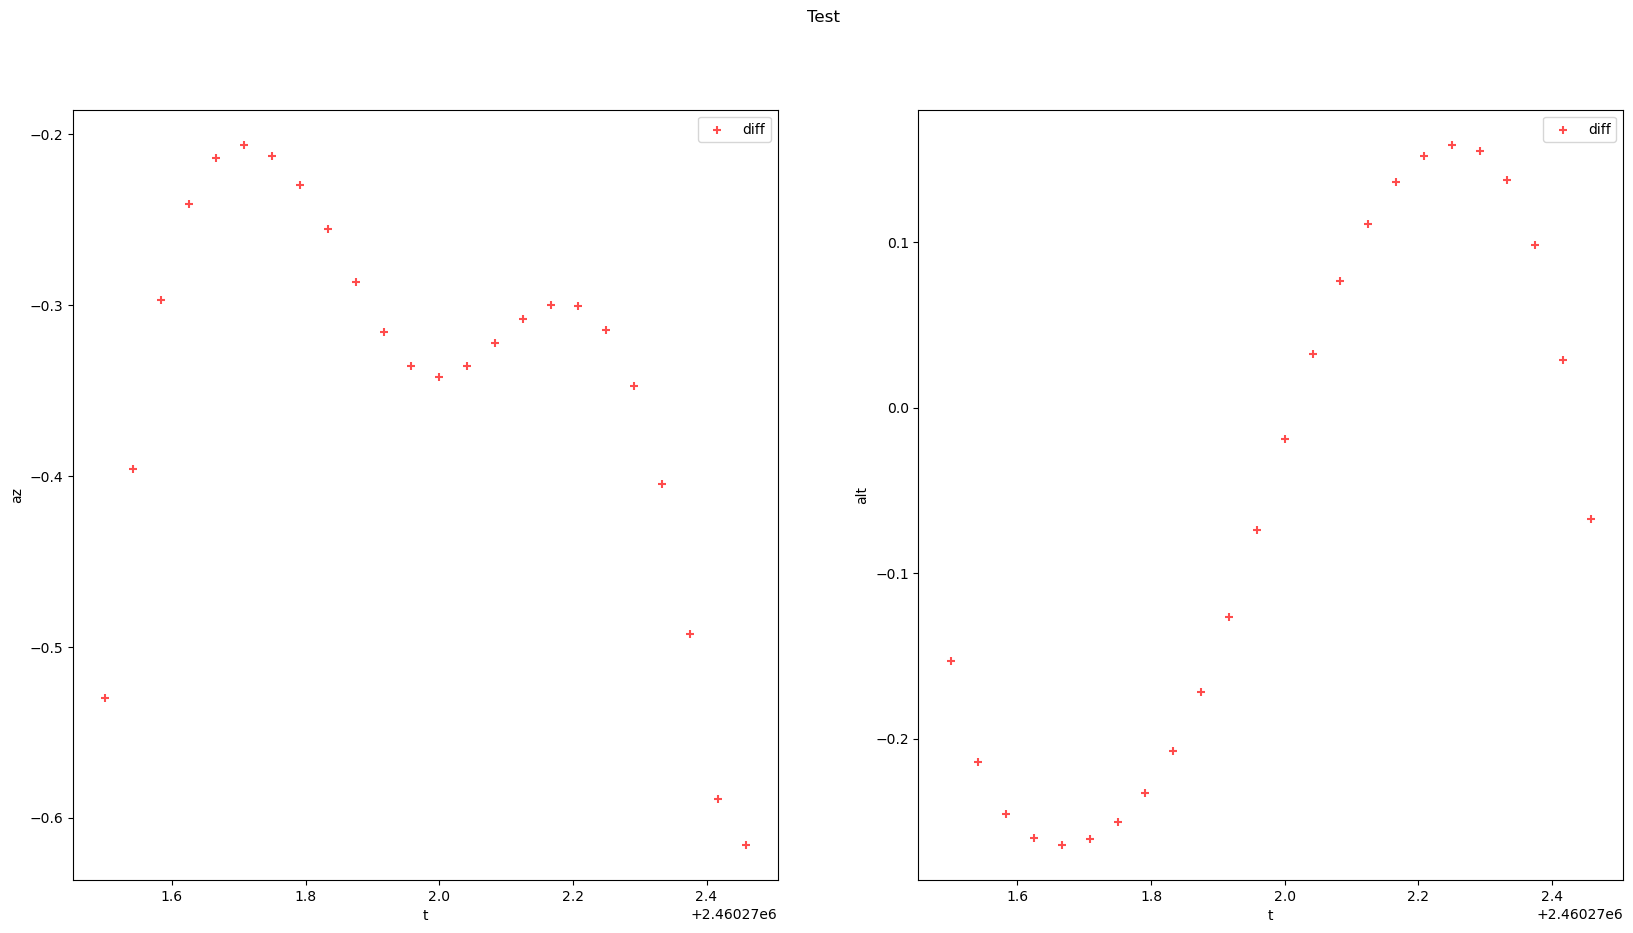

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle('Test')
axs[0].scatter(ts.time.jd, results[:,1,1]- results[:,0,1], marker='+', alpha=0.7, c='red', label='diff')
axs[0].set_xlabel('t')
axs[0].set_ylabel('az')
axs[0].legend()

axs[1].scatter(ts.time.jd, results[:,1,0]-results[:,0,0], marker='+', alpha=0.7, c='red', label='diff')

axs[1].set_xlabel('t')
axs[1].set_ylabel('alt')
axs[1].legend()
plt.show()

In [86]:
result_diff = result[0]-result[1]
print(result_diff*3600)

[ 550.39865929 1895.96187725]


In [11]:
def radec2altaz(_ra,_dec,_lat,_lon,_lst):
    ra = np.deg2rad(_ra)
    dec = np.deg2rad(_dec)
    lat = np.deg2rad(_lat)
    lon = np.deg2rad(_lon)
    lst = np.deg2rad(_lst)
    H = lst - ra
    if(H<0):
        H+=2*np.pi
    if(H>np.pi):
        H=H-2*np.pi

    az = (np.arctan2(np.sin(H), np.cos(H)*np.sin(lat) - np.tan(dec)*np.cos(lat)))-np.pi
    alt = (np.arcsin(np.sin(lat)*np.sin(dec) + np.cos(lat)*np.cos(dec)*np.cos(H)))
    

    if(az<0):
        az+=2*np.pi
    return np.array([np.rad2deg(alt), np.rad2deg(az)])

In [29]:
time2 = datetime.datetime(2000, 6, 7, 12, 38, 35)
coord2 = np.array([308.6635246, -18.4762477])
loc2 = np.array([-79.1099454095946, 55.9116751156616,0])

result2=test_EQ2HOR(coord2, time2, loc2)
result2

array([[  7.8563628 , 167.4540905 ],
       [  7.8537678 , 167.46186742],
       [  7.85623452, 167.45708095]])

In [40]:
results[:,0,1]

array([ 24.04123811,  46.42348444,  64.06540292,  78.33973003,
        90.66893726, 102.07851714, 113.28888465, 124.83162912,
       137.09775168, 150.31255487, 164.4564725 , 179.20210834,
       193.98110956, 208.21076036, 221.53139835, 233.89210118,
       245.49622633, 256.71942568, 268.07721907, 280.26519622,
       294.26942239, 311.47336804, 333.31870832, 359.43351471])